## 전체적인 시각화

In [13]:
import pandas as pd

# 파일 불러오기
df = pd.read_csv("data/item_equipment/merged/total_item_merged.csv")

/var/folders/1k/kfyrfwj51r7_zts1bndgk56c0000gn/T/ipykernel_47505/2775389906.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=world_counts.index, y=world_counts.values, palette='viridis')


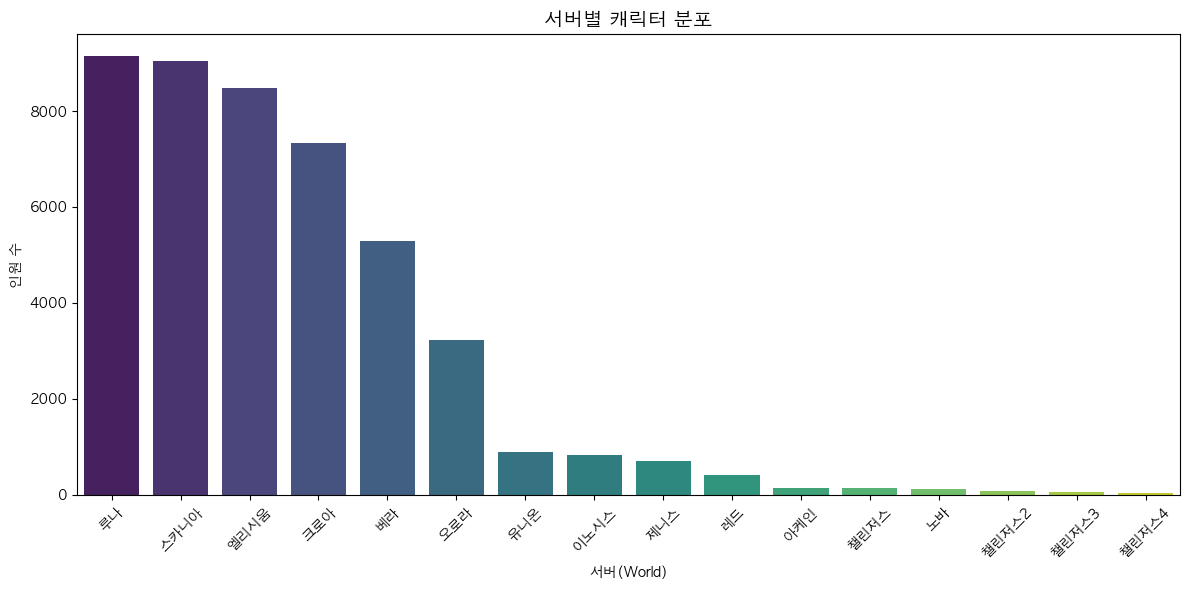

In [151]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (애플)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 중복 제거 (즉, 한 사람당 한 번만 카운트)
df_unique = df[['nickname', 'world']].drop_duplicates()

# 서버별 인원 수 집계
world_counts = df_unique['world'].value_counts().sort_values(ascending=False)

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(x=world_counts.index, y=world_counts.values, palette='viridis')
plt.title('서버별 캐릭터 분포', fontsize=14)
plt.xlabel('서버(World)')
plt.ylabel('인원 수')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

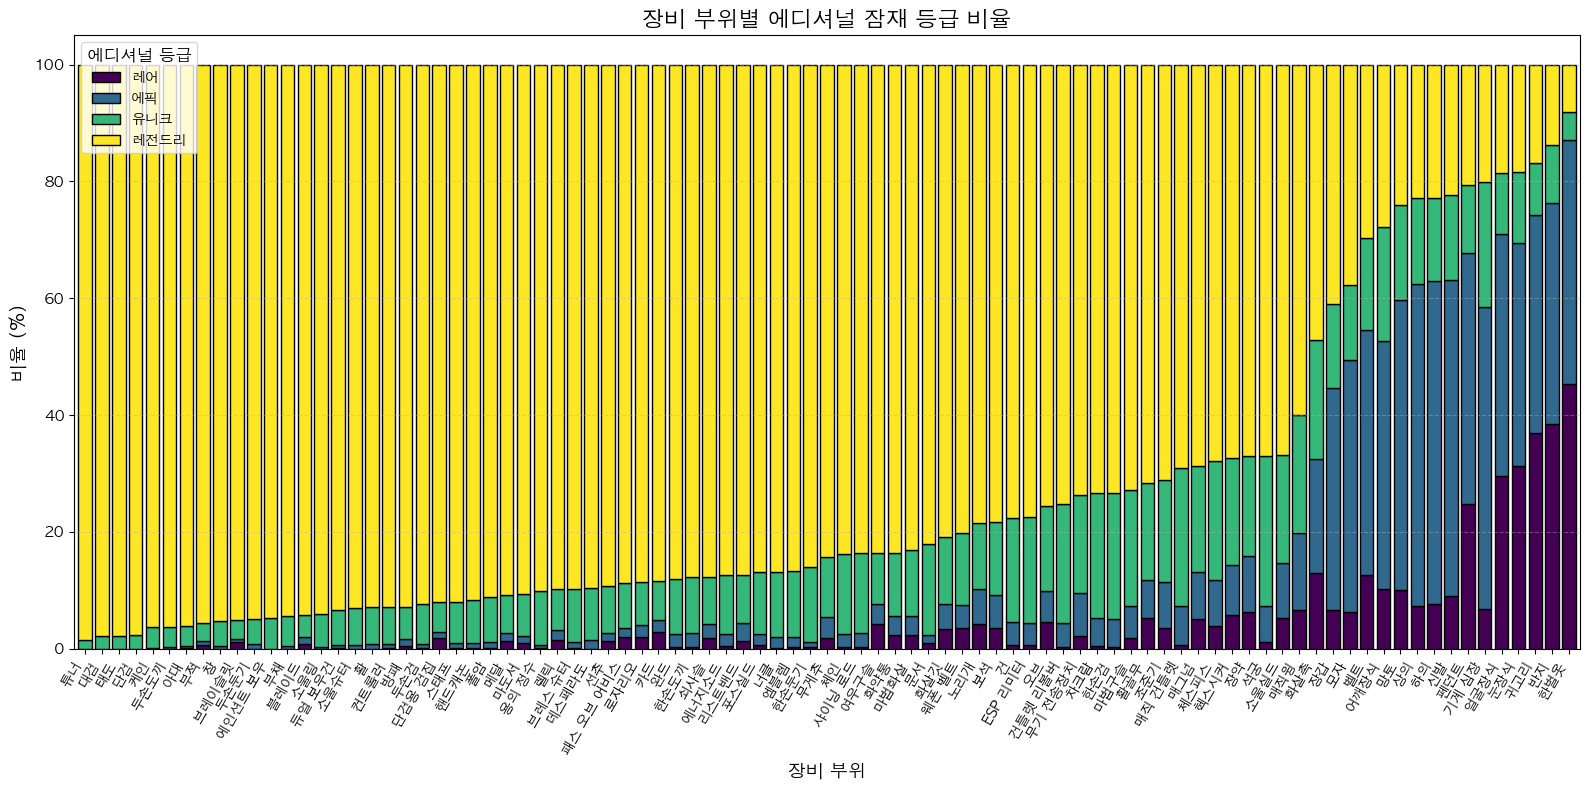

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

# 한글 폰트 설정 (애플)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 등급별 비율 계산
grade_ratio = pd.crosstab(
    df['equipment_part'],
    df['additional_potential_option_grade'],
    normalize='index'
)

grades = ['레어', '에픽', '유니크', '레전드리']
available_grades = [g for g in grades if g in grade_ratio.columns]
grade_ratio = grade_ratio[available_grades] * 100

# 레전드리 비율 높은 순으로 정렬
if '레전드리' in grade_ratio.columns:
    grade_ratio = grade_ratio.sort_values(by='레전드리', ascending=False)

# 시각화
fig, ax = plt.subplots(figsize=(16, 8))
grade_ratio.plot(
    kind='bar',
    stacked=True,
    colormap='viridis',
    width=0.8,
    edgecolor='black',
    ax=ax
)

ax.set_title("장비 부위별 에디셔널 잠재 등급 비율", fontsize=16, fontweight='bold')
ax.set_xlabel("장비 부위", fontsize=13)
ax.set_ylabel("비율 (%)", fontsize=13)
ax.set_xticklabels(ax.get_xticklabels(), rotation=60, ha='right', fontsize=10)
ax.tick_params(axis='y', labelsize=11)
ax.legend(title="에디셔널 등급", title_fontsize=12, fontsize=10, loc="upper left")
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.subplots_adjust(bottom=0.25)  # x축 레이블 여백 확보
plt.tight_layout()
plt.show()

## 가설1 : 에디셔널이 레전드리인 장비는 에디셔널이 유니크인 장비 보다 주스탯 평균이 낮을 것이다.

In [15]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 특수 옵션 키워드 정의
special_keywords = ["공격 시", "공격력", "데미지", "마력", "메소 획득량", "모든 속성 내성", "모든 스킬의 MP 소모", "모든 스킬의 재사용 대기시간", 
                    "몬스터 방어율 무시", "방어력", "보스 몬스터 공격 시 데미지", "상태 이상 내성", "아이템 드롭률", "올스탯", "점프력", "최대 HP", 
                    "최대 MP", "캐릭터 기준", "크리티컬 데미지", "크리티컬 확률"
]

# 2. 주스탯(LUK, STR, DEX, INT) 추출 함수
def extract_stat_values(row):
    result = {
        'str_percent': 0, 'str_flat': 0,
        'dex_percent': 0, 'dex_flat': 0,
        'int_percent': 0, 'int_flat': 0,
        'luk_percent': 0, 'luk_flat': 0,
    }
    
    for col in ['additional_potential_option_1', 'additional_potential_option_2', 'additional_potential_option_3']:
        val = row.get(col, '')
        if isinstance(val, str):
            for stat in ['STR', 'DEX', 'INT', 'LUK']:
                # 퍼센트 추출 (예: STR : +6%)
                percent_match = re.search(fr'{stat}\s*:\s*\+(\d+)%', val)
                if percent_match:
                    result[f'{stat.lower()}_percent'] += int(percent_match.group(1))
                # 절대 수치 추출 (예: STR : +6)
                flat_match = re.search(fr'{stat}\s*:\s*\+(\d+)(?!%)', val)
                if flat_match:
                    result[f'{stat.lower()}_flat'] += int(flat_match.group(1))
                    
    return pd.Series(result)

# 3. 특수 옵션 포함 여부 확인 함수
def has_special_option(row):
    for col in ['additional_potential_option_1', 'additional_potential_option_2', 'additional_potential_option_3']:
        val = row.get(col, '')
        if isinstance(val, str):
            for keyword in special_keywords:
                if keyword in val:
                    return 1
    return 0

# 4. 전처리 - 새로운 컬럼 생성
df = df.join(df.apply(extract_stat_values, axis=1))
df['has_special'] = df.apply(has_special_option, axis=1)

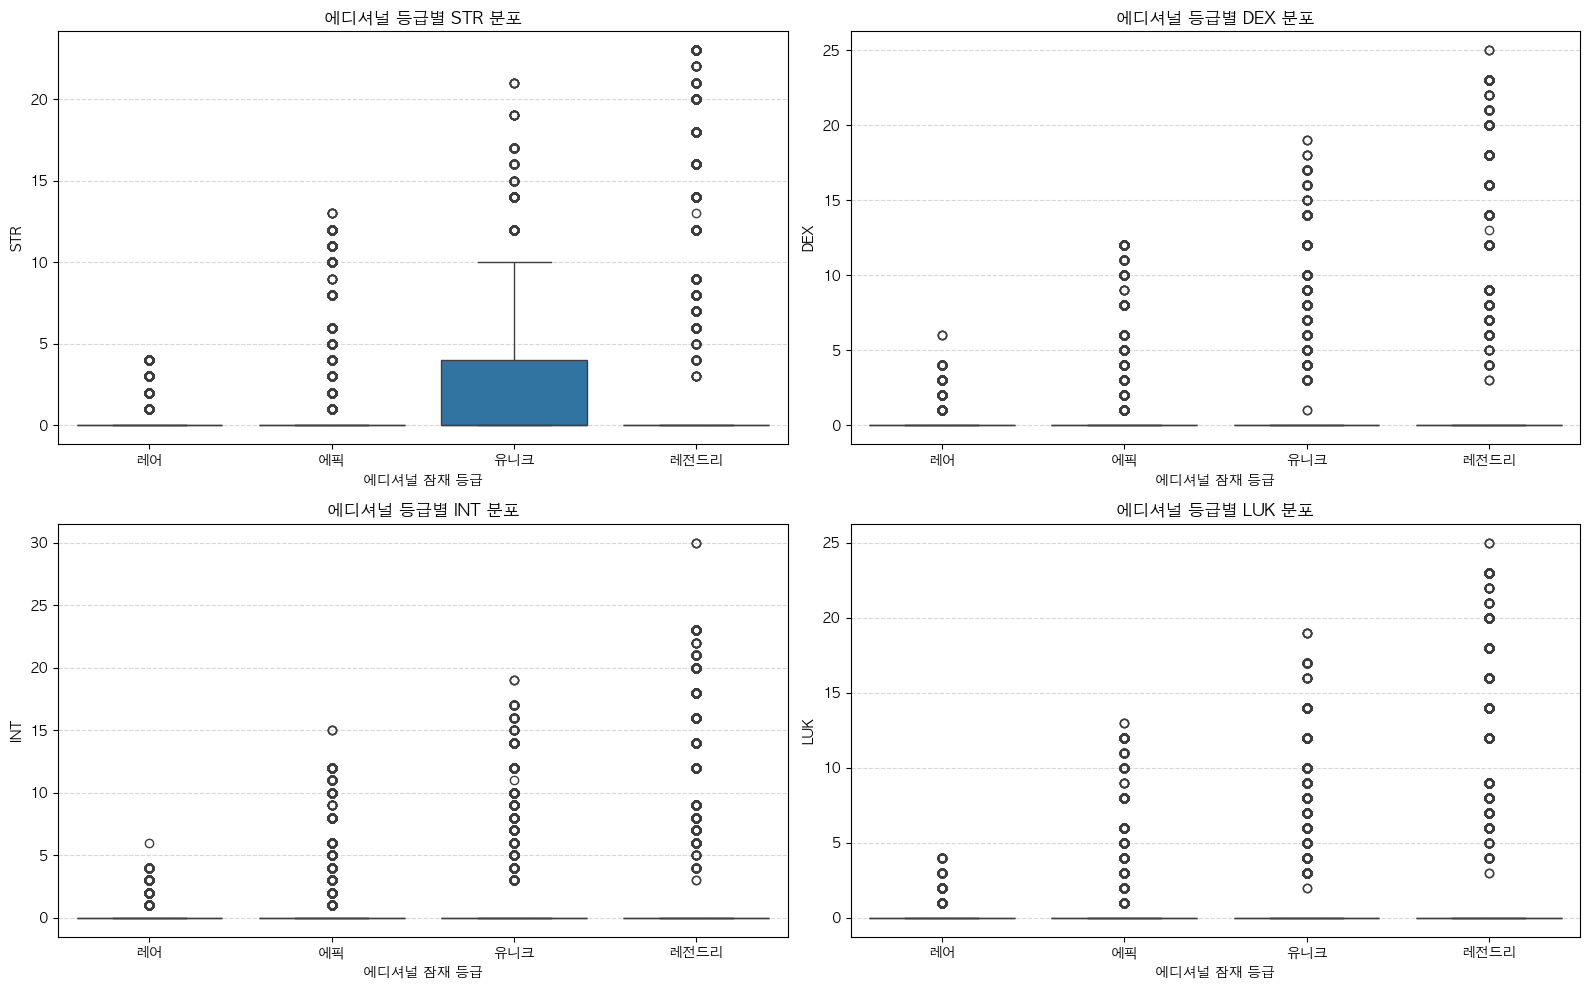

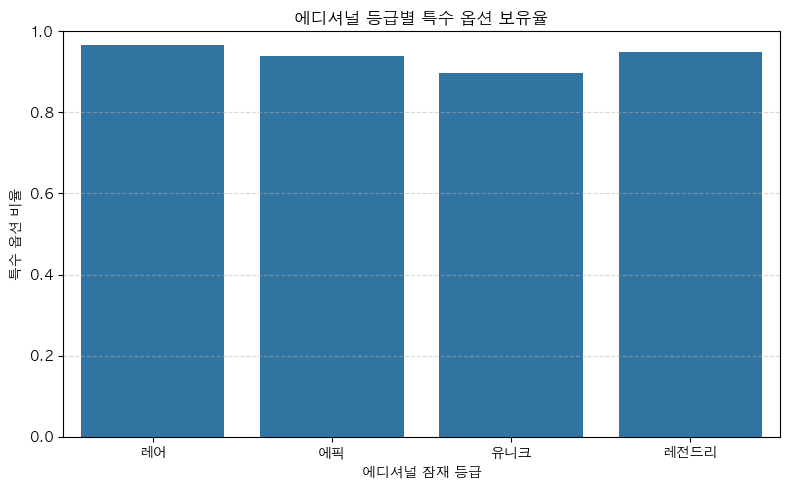

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

# 5. 박스플롯: 에디셔널 등급별 주스탯 분포
plt.figure(figsize=(16, 10))

stats = ['str_percent', 'dex_percent', 'int_percent', 'luk_percent']
stat_labels = ['STR', 'DEX', 'INT', 'LUK']

for i, (stat, label) in enumerate(zip(stats, stat_labels), 1):
    plt.subplot(2, 2, i)
    sns.boxplot(
        data=df,
        x='additional_potential_option_grade', 
        y=stat,
        order=['레어', '에픽', '유니크', '레전드리']
    )
    plt.title(f"에디셔널 등급별 {label} 분포")
    plt.xlabel("에디셔널 잠재 등급")
    plt.ylabel(f"{label}")
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# 6. 막대그래프 : 특수 옵션 비율
special_rate = df.groupby('additional_potential_option_grade')['has_special'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(data=special_rate, x='additional_potential_option_grade', y='has_special', order=['레어', '에픽', '유니크', '레전드리'])
plt.title("에디셔널 등급별 특수 옵션 보유율")
plt.xlabel("에디셔널 잠재 등급")
plt.ylabel("특수 옵션 비율")
plt.ylim(0, 1)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

1. 에디셔널 등급별 STR, DEX, INT, LUK 분포(주스탯 기준)
- 레전드리 > 유니크 > 에픽 > 레어 순으로 능력치 분포의 최대값이 증가함.
- 레전드리 등급에서는 모든 능력치(STR, DEX, INT, LUK)에 대해 최댓값이 가장 큼.
- 이상치(outlier)가 굉장히 많이 보이는데, 특히 레전드리에서 높은 수치들이 분산돼 있음.
- 인사이트 : 에디셔널 잠재옵션의 주스탯 세팅은 높은 등급일수록 확률적으로 더 좋은 수치를 가짐. 이는 잠재옵션 재세팅에 있어서 등급 업그레이드가 중요한 이유를 설명해줌

2. 에디셔널 등급별 특수 옵션 포함 비율
- 특수 옵션 예시: 아이템 드롭률, 메소 획득량, 재사용 대기시간 감소 등 유틸성 옵션들
- 전 그래프와 달리 레전드리, 유니크와 같은 높은 등급보다 레어, 에픽과 같은 낮은 등급에서 특수 옵션의 보유율이 높은것을 알수 있음

In [27]:
import pandas as pd
import re
from scipy.stats import f_oneway
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df['additional_potential_option_grade'] = df['additional_potential_option_grade'].astype(str)

# 7. 주스탯 퍼센트+절댓값 합산 컬럼 생성
df['main_stat_total'] = df[['str_percent', 'str_flat', 'dex_percent', 'dex_flat', 
                            'int_percent', 'int_flat', 'luk_percent', 'luk_flat']].sum(axis=1)

# 8. 등급 그룹별 주스탯 평균 차이 검정 (ANOVA)
model = ols('main_stat_total ~ C(additional_potential_option_grade)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print("=== ANOVA 결과 ===")
print(anova_table)

# 9. 사후검정 (Tukey HSD)
print("\n=== Tukey HSD 사후검정 ===")
tukey = pairwise_tukeyhsd(df['main_stat_total'], df['additional_potential_option_grade'])
print(tukey)

=== ANOVA 결과 ===
                                            sum_sq         df             F  \
C(additional_potential_option_grade)  7.654924e+06        3.0  55309.706196   
Residual                              1.187181e+08  2573348.0           NaN   

                                      PR(>F)  
C(additional_potential_option_grade)     0.0  
Residual                                 NaN  

=== Tukey HSD 사후검정 ===
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
   nan     레어   3.7627   0.0    3.73  3.7953   True
   nan   레전드리   8.2428   0.0  8.2148  8.2707   True
   nan     에픽    6.004   0.0  5.9769  6.0311   True
   nan    유니크   8.7246   0.0  8.6889  8.7603   True
    레어   레전드리   4.4801   0.0  4.4492   4.511   True
    레어     에픽   2.2413   0.0  2.2112  2.2715   True
    레어    유니크   4.9619   0.0  4.9239     5.0   True
  레전드리     에픽  -2.2387   0.0 -2.2636 -2.2138   True
  레전드리  

해석 및 결과

- 해석 : 에디셔널 등급별 주스탯 분포를 시각화한 결과, ANOVA 검정에서 유의미한 차이(p-value < 0.05)는 있었지만, Tukey HSD 사후검정을 통해 모든 등급 쌍 사이에 유의미한 차이가 있다는 것을 확인 하였지만 레전드리 유니크의 평균 차이는 아주 작아(+0.48) 실질적 차이는 거의 없다고 볼수도 있음.

- 결과 : 에디셔널 등급이 올라갈수록 주스탯 평균도 높아진다는 일반적 경항이 있지만, 레전드리와 유니크 사이의 평균 차이는 크지 않다.

## 가설2 : 아이템이 고가일수록 잠재능력과 에디셔널의 등급이 둘 다 레전드리인 비율은 낮을것이다.

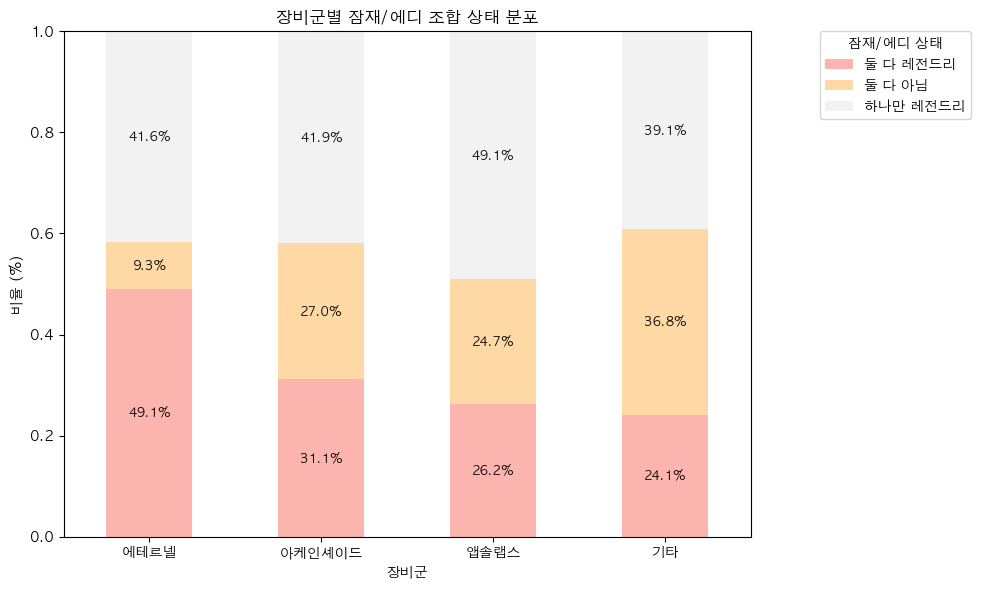

In [100]:
# 파일 불러오기
df = pd.read_csv("data/item_equipment/merged/total_item_merged.csv")

# 장비군 분류 함수
def categorize_item(name):
    if '앱솔랩스' in name:
        return '앱솔랩스'
    elif '아케인셰이드' in name:
        return '아케인셰이드'
    elif '에테르넬' in name:
        return '에테르넬'
    else:
        return '기타'

df['장비군'] = df['item_name'].apply(categorize_item)

# 잠재/에디 조합 상태 구분
def categorize_potential(row):
    pot = row['potential_option_grade']
    add = row['additional_potential_option_grade']
    if pot == '레전드리' and add == '레전드리':
        return '둘 다 레전드리'
    elif pot == '레전드리' or add == '레전드리':
        return '하나만 레전드리'
    else:
        return '둘 다 아님'

df['잠재상태'] = df.apply(categorize_potential, axis=1)

# 장비군 순서 고정
order = ['에테르넬', '아케인셰이드', '앱솔랩스', '기타']
df['장비군'] = pd.Categorical(df['장비군'], categories=order, ordered=True)

# 교차표 비율 계산
status_ratio = df.groupby(['장비군', '잠재상태'], observed=False).size().unstack().fillna(0)
status_ratio = status_ratio.div(status_ratio.sum(axis=1), axis=0)  # 비율로 변환

# 누적 막대그래프
ax = status_ratio.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Pastel1')
plt.title('장비군별 잠재/에디 조합 상태 분포')
plt.ylabel('비율 (%)')
plt.ylim(0, 1)
plt.xticks(rotation=0)
# plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title='잠재/에디 상태', loc='upper left', bbox_to_anchor=(1.1, 1), borderaxespad=0.)
plt.tight_layout()

# 수치 라벨 추가
for i, (index, row) in enumerate(status_ratio.iterrows()):
    cum_sum = 0
    for category in status_ratio.columns:
        value = row[category]
        if value > 0.02:  # 2% 이상일 때만 표시
            ax.text(
                i, cum_sum + value / 2,
                f'{value*100:.1f}%',
                ha='center', va='center', fontsize=9, color='black'
            )
        cum_sum += value

plt.show()

In [92]:
import pandas as pd
from scipy.stats import chi2_contingency
import numpy as np

# 교차표 생성 (장비군 vs 잠재상태)
contingency_table = pd.crosstab(df['장비군'], df['잠재상태'])

# 카이제곱 검정 수행
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Cramér's V 계산
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

# 출력
print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p)
print("Cramér's V:", cramers_v)

# 해석
alpha = 0.05
if p < alpha:
    print("귀무가설 기각: 장비군과 잠재/에디 조합 상태는 독립이 아님 → 상관관계 있음.")
else:
    print("귀무가설 채택: 장비군과 잠재/에디 조합 상태는 독립임 → 상관관계 없음.")

Chi-square statistic: 75903.93090995013
Degrees of freedom: 6
P-value: 0.0
Cramér's V: 0.10901068206905731
귀무가설 기각: 장비군과 잠재/에디 조합 상태는 독립이 아님 → 상관관계 있음.


해석 및 결과
- 해석 : 각 방어구 세트와 잠재/에디 상태 간의 차이를 시각화한 결과, 카이제곱 검정에서 유의미한 차이(p-value < 0.05)는 있었지만, 효과크기(Cramér's V = 0.109)는 매우 작아 가격대와 옵션간의 관계의 크기는 미미함

- 결과 : 아이템이 고가일수록 잠재능력과 에디셔널의 등급이 둘 다 레전드리인 비율은 높지만, 그 관계의 크기(상관성)는 매우 작음

## 가설3 : 황금망치가 적용된 장비는 잠재능력 등급이 높을 가능성이 높다.

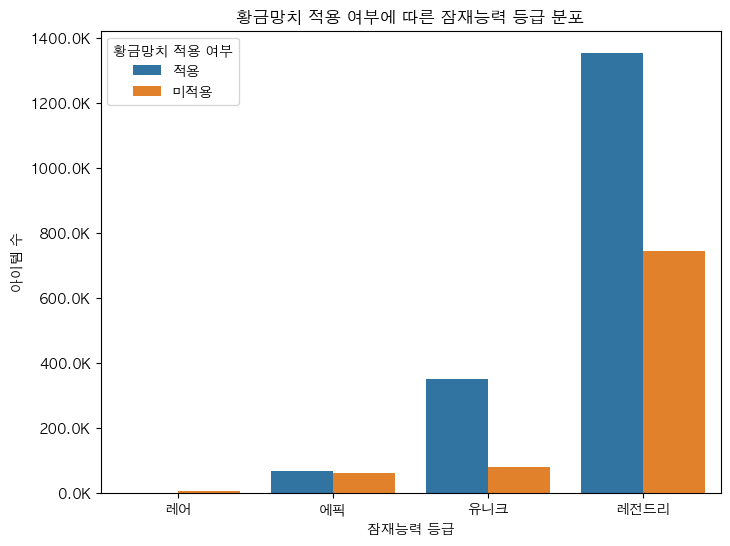

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("data/item_equipment/merged/total_item_merged.csv")

# 잠재능력 등급을 순서형 변수로 변환
grade_order = ['레어', '에픽', '유니크', '레전드리']
df['potential_option_grade'] = pd.Categorical(df['potential_option_grade'], categories=grade_order, ordered=True)

# 막대 그래프
plt.figure(figsize=(8, 6))
sns.countplot(x='potential_option_grade', hue='golden_hammer_flag', data=df)
plt.title('황금망치 적용 여부에 따른 잠재능력 등급 분포')
plt.xlabel('잠재능력 등급')
plt.ylabel('아이템 수')

# y축 값 1000으로 나누어 천 단위로 표시
formatter = FuncFormatter(lambda x, _: f'{x / 1000:.1f}K')  # 1,000 단위로 표시
plt.gca().yaxis.set_major_formatter(formatter)

plt.legend(title='황금망치 적용 여부', labels=['적용', '미적용'])
plt.show()

In [85]:
import pandas as pd
import scipy.stats as stats

# 교차 테이블 생성 (황금망치 적용 여부와 잠재능력 등급 간의 빈도 표)
contingency_table = pd.crosstab(df['golden_hammer_flag'], df['potential_option_grade'])

# 카이제곱 검정 수행
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Cramér's V 계산
n = contingency_table.sum().sum()
min_dim = min(contingency_table.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

# 결과 출력
print("Chi-square statistic:", chi2)
print("Degrees of freedom:", dof)
print("P-value:", p)
print("Cramér's V:", cramers_v)

# p-값에 따른 결론
if p < 0.05:
    print("귀무가설을 기각합니다. 황금망치 적용 여부와 잠재능력 등급 간에 유의미한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 황금망치 적용 여부와 잠재능력 등급 간에 유의미한 관계가 없습니다.")

Chi-square statistic: 70759.67858273858
Degrees of freedom: 3
P-value: 0.0
Cramér's V: 0.16301940717717667
귀무가설을 기각합니다. 황금망치 적용 여부와 잠재능력 등급 간에 유의미한 관계가 있습니다.


해석 및 결과

- 해석 : 황금망치 적용 여부와 잠재능력 등급간의 차이를 시각화한 결과, 카이제곱 검정에서 유의미한 차이(p-value < 0.05)는 있었지만, 효과크기(Cramér's V = 0.163)는 매우 작아 황금망치 적용 여부와 잠재능력 등급 간의 관계의 크기는 미미함

- 결과 : 황금망치의 적용한 장비일수록 잠재능력의 등급이 높지만, 그 관계의 크기는 매우 작음